In [185]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from prophet import Prophet
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Bidirectional
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, ParameterGrid
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [186]:
df = pd.read_excel("Data Penghasilan Tidak Tetap.xlsx")
df.drop(columns="Saldo Akhir", inplace = True)
df.head(10)

,Tanggal,Saldo Awal,Pemasukan,Pengeluaran
0,2024-01-01,1500000,120000,80000
1,2024-01-02,1540000,135000,75000
2,2024-01-03,1600000,110000,90000
3,2024-01-04,1620000,145000,70000
4,2024-01-05,1695000,130000,85000
5,2024-01-06,1740000,150000,95000
6,2024-01-07,1795000,100000,60000
7,2024-01-08,1835000,140000,80000
8,2024-01-09,1895000,125000,75000
9,2024-01-10,1945000,135000,90000


In [187]:
df.isna().sum()

Tanggal        0
Saldo Awal     0
Pemasukan      0
Pengeluaran    0
dtype: int64

In [188]:
len(df)

182

In [189]:
df_masuk = df[["Tanggal","Pemasukan"]]
df_luar = df[["Tanggal","Pengeluaran"]]

In [190]:
df_masuk['ds'] = pd.to_datetime(df_masuk['Tanggal'])
df_masuk['y'] = df_masuk['Pemasukan']

In [191]:
df_masuk = df_masuk.drop(columns=["Tanggal", "Pemasukan"])
df_masuk.columns

Index(['ds', 'y'], dtype='object')

In [192]:
df_masuk_test = df_masuk.tail(30)
df_masuk_train = df_masuk.head(152)

In [193]:
df_luar['ds'] = pd.to_datetime(df_luar['Tanggal'])
df_luar['y'] = df_luar['Pengeluaran']

In [194]:
df_luar = df_luar.drop(columns=["Tanggal", "Pengeluaran"])
df_luar.columns

Index(['ds', 'y'], dtype='object')

In [195]:
df_luar_test = df_luar.tail(30)
df_luar_train = df_luar.head(152)

<Axes: >

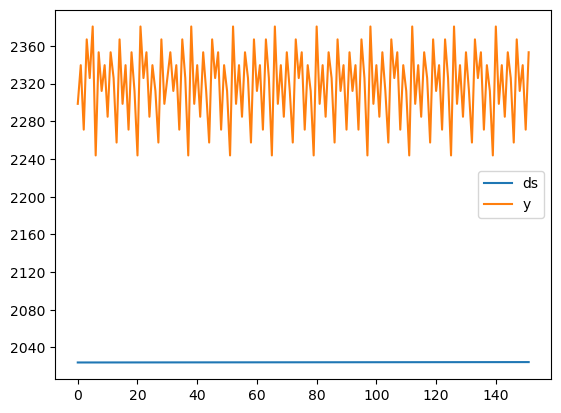

In [196]:
df_masuk_train.plot()

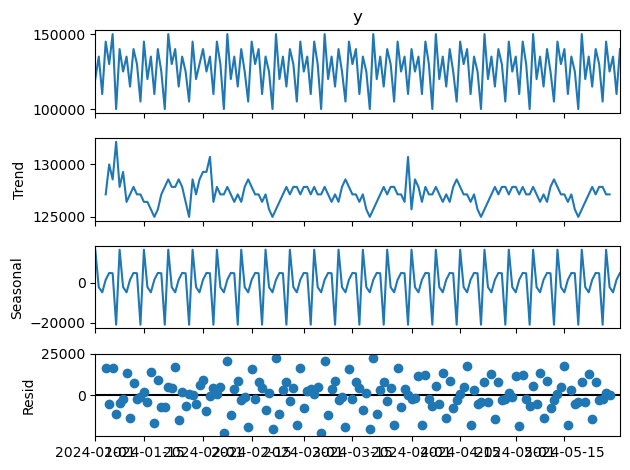

In [197]:
temp1 = df_masuk_train
temp1.set_index("ds", inplace=True)
result = seasonal_decompose(temp1["y"])
result.plot();

<Axes: >

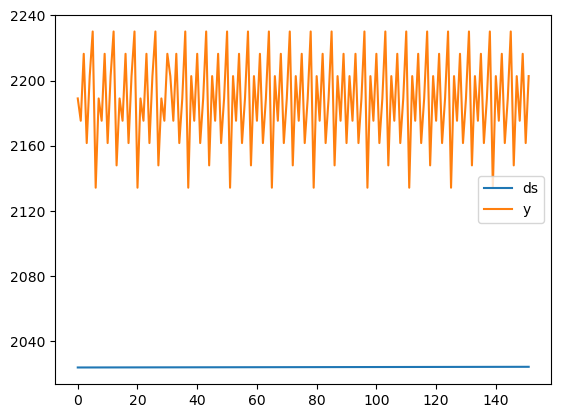

In [198]:
df_luar_train.plot()

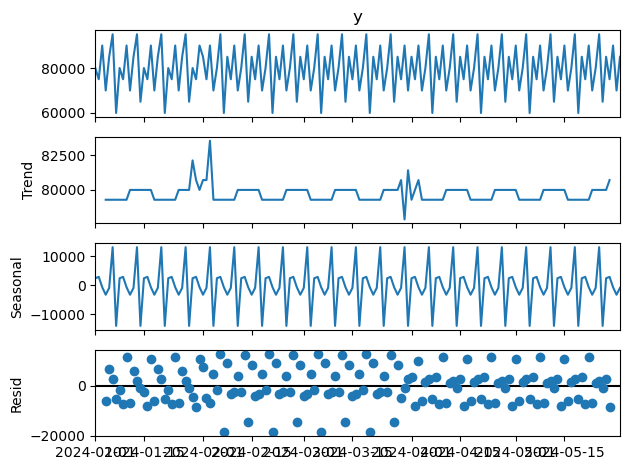

In [199]:
temp2 = df_luar_train
temp2.set_index("ds", inplace=True)
result = seasonal_decompose(temp2["y"])
result.plot();

In [200]:
df_masuk_train.reset_index(inplace=True)
df_luar_train.reset_index(inplace=True)
print(df_masuk_train.columns)
print(df_masuk_test.columns)

Index(['ds', 'y'], dtype='object')
Index(['ds', 'y'], dtype='object')


In [201]:
# Total Uang yang akan diprediksi 10.155.000
uang_akhir = 10155000
df.tail()

,Tanggal,Saldo Awal,Pemasukan,Pengeluaran
177,2024-06-26,9925000,130000,95000
178,2024-06-27,9960000,105000,65000
179,2024-06-28,10000000,145000,85000
180,2024-06-29,10060000,125000,75000
181,2024-06-30,10110000,135000,90000


In [202]:
saldo_awal = 8730000
df[150:160]

,Tanggal,Saldo Awal,Pemasukan,Pengeluaran
150,2024-05-30,8635000,110000,70000
151,2024-05-31,8675000,140000,85000
152,2024-06-01,8730000,125000,75000
153,2024-06-02,8780000,135000,90000
154,2024-06-03,8825000,110000,70000
155,2024-06-04,8865000,145000,80000
156,2024-06-05,8930000,130000,95000
157,2024-06-06,8965000,100000,60000
158,2024-06-07,9005000,150000,85000
159,2024-06-08,9070000,120000,75000


In [203]:
nama_metode = []
saldo_akhir = []
error = []

## Using Prophet

In [205]:
def prophet_forecast(train, test, params):
    model = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        seasonality_mode=params['seasonality_mode']
    )
    model.fit(train)
    forecast = model.predict(test[['ds']])
    return forecast['yhat']

# Hyperparameter yang akan dituning
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

In [206]:
# Grid Search Manual
grid = ParameterGrid(param_grid)

# Data splitting (Contoh, data di-split 80% train dan 20% test)
train_size = int(len(df_masuk) * 0.8)
train = df_masuk[:train_size]
test = df_masuk[train_size:]

best_params = None
best_mae = float('inf')

# Looping melalui grid search
for params in grid:
    forecast = prophet_forecast(train, test, params)
    mae = mean_absolute_error(test['y'], forecast)
    print(f"Params: {params}, MAE: {mae}")

    # Jika hasil MAE lebih baik, simpan parameter terbaik
    if mae < best_mae:
        best_mae = mae
        best_params = params

print(f"Best Parameters: {best_params}, Best MAE: {best_mae}")

19:56:33 - cmdstanpy - INFO - Chain [1] start processing
19:56:34 - cmdstanpy - INFO - Chain [1] done processing
19:56:34 - cmdstanpy - INFO - Chain [1] start processing


Params: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}, MAE: 16074.45486957666


19:56:34 - cmdstanpy - INFO - Chain [1] done processing
19:56:35 - cmdstanpy - INFO - Chain [1] start processing


Params: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}, MAE: 16144.603045300653


19:56:35 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}, MAE: 16170.262115379684


19:56:35 - cmdstanpy - INFO - Chain [1] start processing
19:56:35 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}, MAE: 16158.84808767541


19:56:36 - cmdstanpy - INFO - Chain [1] start processing
19:56:36 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}, MAE: 16145.268426770781


19:56:37 - cmdstanpy - INFO - Chain [1] start processing
19:56:37 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}, MAE: 16157.252128909518


19:56:38 - cmdstanpy - INFO - Chain [1] start processing
19:56:38 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}, MAE: 16186.733639531782


19:56:38 - cmdstanpy - INFO - Chain [1] start processing
19:56:39 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}, MAE: 16208.784718596075


19:56:39 - cmdstanpy - INFO - Chain [1] start processing
19:56:40 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}, MAE: 16201.872264162248


19:56:40 - cmdstanpy - INFO - Chain [1] start processing
19:56:41 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}, MAE: 16155.827840659145


19:56:41 - cmdstanpy - INFO - Chain [1] start processing
19:56:41 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}, MAE: 16201.29351013021


19:56:42 - cmdstanpy - INFO - Chain [1] start processing
19:56:42 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}, MAE: 16207.304721709264


19:56:42 - cmdstanpy - INFO - Chain [1] start processing
19:56:43 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}, MAE: 16189.262499749118


19:56:43 - cmdstanpy - INFO - Chain [1] start processing
19:56:43 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}, MAE: 16217.0456296081


19:56:43 - cmdstanpy - INFO - Chain [1] start processing
19:56:44 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}, MAE: 16221.730203469207


19:56:44 - cmdstanpy - INFO - Chain [1] start processing
19:56:44 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}, MAE: 16166.753406050904


19:56:45 - cmdstanpy - INFO - Chain [1] start processing
19:56:45 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}, MAE: 16211.591277619085


19:56:45 - cmdstanpy - INFO - Chain [1] start processing
19:56:45 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}, MAE: 16213.777758716766
Best Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}, Best MAE: 16074.45486957666


In [207]:
best_params = {
    'changepoint_prior_scale': 0.5,
    'seasonality_prior_scale': 10.0,
    'seasonality_mode': 'multiplicative'
}

# Buat model Prophet dengan parameter terbaik
best_model = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    seasonality_mode=best_params['seasonality_mode']
)

# Fit model pada seluruh dataset training
best_model.fit(df_masuk_train)

# Prediksi pada data baru atau test set
future = best_model.make_future_dataframe(periods=30)  # Menentukan berapa banyak data yang akan diprediksi
forecast = best_model.predict(future)

# Tampilkan hasil prediksi
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

19:56:46 - cmdstanpy - INFO - Chain [1] start processing
19:56:46 - cmdstanpy - INFO - Chain [1] done processing


            ds           yhat     yhat_lower     yhat_upper
0   2024-01-01  141847.170016  127174.307786  154669.574798
1   2024-01-02  124974.792725  111822.367961  138430.108974
2   2024-01-03  121885.008414  108445.941123  135210.764318
3   2024-01-04  127390.148772  114119.209985  140782.001218
4   2024-01-05  132219.424521  118635.161805  145918.977915
..         ...            ...            ...            ...
177 2024-06-26  122449.562710  110002.144736  135471.130272
178 2024-06-27  127896.518480  114289.694512  141923.923623
179 2024-06-28  132658.246463  119751.094151  146278.168407
180 2024-06-29  132065.257777  118628.191722  145679.362173
181 2024-06-30  106604.961375   92965.891077  119659.817549

[182 rows x 4 columns]


In [208]:
df_masuk_test["yhat"] = forecast["yhat"].tail(30)
df_masuk_test.head()

,ds,y,yhat
152,2024-06-01,125000,132095.060125
153,2024-06-02,135000,106629.018450
154,2024-06-03,110000,142715.058306
155,2024-06-04,145000,125657.124524
156,2024-06-05,130000,122470.286535


In [209]:
df_masuk_test.set_index("ds", inplace = True)

<Axes: xlabel='ds'>

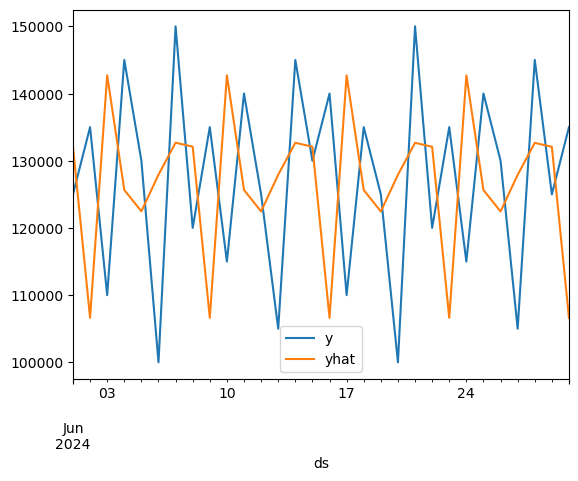

In [210]:
df_masuk_test.plot()

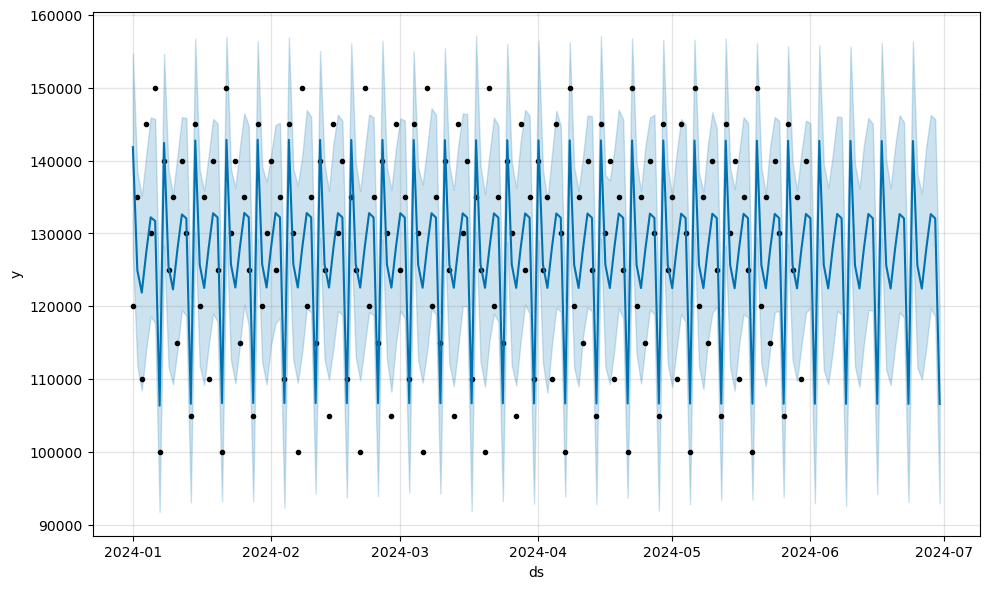

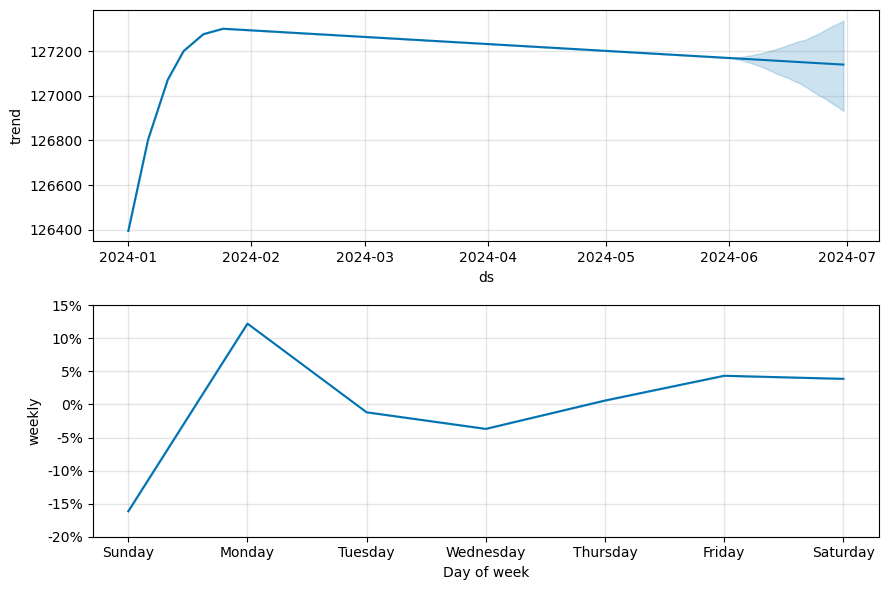

In [211]:
best_model.plot(forecast)
plt.show()

best_model.plot_components(forecast)
plt.show()

In [212]:
def prophet_forecast(train, test, params):
    model = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        seasonality_mode=params['seasonality_mode']
    )
    model.fit(train)
    forecast = model.predict(test[['ds']])
    return forecast['yhat']

# Hyperparameter yang akan dituning
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

In [213]:
# Grid Search Manual
grid = ParameterGrid(param_grid)

# Data splitting (Contoh, data di-split 80% train dan 20% test)
train_size = int(len(df_luar) * 0.8)
train = df_luar[:train_size]
test = df_luar[train_size:]

best_params = None
best_mae = float('inf')

# Looping melalui grid search
for params in grid:
    forecast = prophet_forecast(train, test, params)
    mae = mean_absolute_error(test['y'], forecast)
    print(f"Params: {params}, MAE: {mae}")

    # Jika hasil MAE lebih baik, simpan parameter terbaik
    if mae < best_mae:
        best_mae = mae
        best_params = params

print(f"Best Parameters: {best_params}, Best MAE: {best_mae}")

19:56:48 - cmdstanpy - INFO - Chain [1] start processing
19:56:49 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}, MAE: 12175.588178980057


19:56:49 - cmdstanpy - INFO - Chain [1] start processing
19:56:49 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}, MAE: 12219.386380939322


19:56:50 - cmdstanpy - INFO - Chain [1] start processing
19:56:50 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}, MAE: 12231.009121962627


19:56:50 - cmdstanpy - INFO - Chain [1] start processing
19:56:51 - cmdstanpy - INFO - Chain [1] done processing
19:56:51 - cmdstanpy - INFO - Chain [1] start processing


Params: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}, MAE: 11907.275936191432


19:56:51 - cmdstanpy - INFO - Chain [1] done processing
19:56:52 - cmdstanpy - INFO - Chain [1] start processing


Params: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}, MAE: 11968.45166238287


19:56:52 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}, MAE: 11968.26672972715


19:56:52 - cmdstanpy - INFO - Chain [1] start processing
19:56:53 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}, MAE: 12049.036638665053


19:56:53 - cmdstanpy - INFO - Chain [1] start processing
19:56:53 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}, MAE: 12077.253958003223


19:56:54 - cmdstanpy - INFO - Chain [1] start processing
19:56:54 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}, MAE: 12077.37169215652


19:56:55 - cmdstanpy - INFO - Chain [1] start processing
19:56:55 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}, MAE: 12027.631053181347


19:56:55 - cmdstanpy - INFO - Chain [1] start processing
19:56:56 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}, MAE: 12059.366494676698


19:56:56 - cmdstanpy - INFO - Chain [1] start processing
19:56:57 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}, MAE: 12059.76359939194


19:56:57 - cmdstanpy - INFO - Chain [1] start processing
19:56:57 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}, MAE: 12054.07901986679


19:56:58 - cmdstanpy - INFO - Chain [1] start processing
19:56:58 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}, MAE: 12082.383355583668


19:56:58 - cmdstanpy - INFO - Chain [1] start processing
19:56:59 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}, MAE: 12082.626906210668


19:56:59 - cmdstanpy - INFO - Chain [1] start processing
19:56:59 - cmdstanpy - INFO - Chain [1] done processing
19:56:59 - cmdstanpy - INFO - Chain [1] start processing


Params: {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}, MAE: 12047.105013475108


19:57:00 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}, MAE: 12089.989714917338


19:57:00 - cmdstanpy - INFO - Chain [1] start processing
19:57:01 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}, MAE: 12090.342829909006
Best Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}, Best MAE: 11907.275936191432


In [214]:
best_params = {
    'changepoint_prior_scale': 0.01,
    'seasonality_prior_scale': 0.1,
    'seasonality_mode': 'multiplicative'
}

# Buat model Prophet dengan parameter terbaik
best_model = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    seasonality_mode=best_params['seasonality_mode']
)

# Fit model pada seluruh dataset training
best_model.fit(df_luar_train)

# Prediksi pada data baru atau test set
future = best_model.make_future_dataframe(periods=30)  # Menentukan berapa banyak data yang akan diprediksi
forecast = best_model.predict(future)

# Tampilkan hasil prediksi
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

19:57:01 - cmdstanpy - INFO - Chain [1] start processing
19:57:01 - cmdstanpy - INFO - Chain [1] done processing


            ds          yhat    yhat_lower     yhat_upper
0   2024-01-01  80435.375035  71889.572524   89694.202668
1   2024-01-02  80654.951953  71269.640104   89492.761178
2   2024-01-03  78475.039593  69689.563846   88073.749191
3   2024-01-04  74770.394512  65025.555620   84202.011300
4   2024-01-05  77618.810897  68265.230614   86635.088361
..         ...           ...           ...            ...
177 2024-06-26  82122.729203  72213.504056   92058.160989
178 2024-06-27  78244.853528  69019.115611   87487.343683
179 2024-06-28  81224.561835  71664.386464   90405.972129
180 2024-06-29  95088.894706  85898.441472  105007.278247
181 2024-06-30  67804.175789  57675.475406   77227.025946

[182 rows x 4 columns]


In [215]:
df_luar_test["yhat"] = forecast["yhat"].tail(30)
df_luar_test.head()

,ds,y,yhat
152,2024-06-01,75000,94414.174668
153,2024-06-02,90000,67323.181183
154,2024-06-03,70000,83727.869850
155,2024-06-04,80000,83955.441844
156,2024-06-05,95000,81685.359451


In [216]:
df_luar_test.set_index("ds", inplace = True)

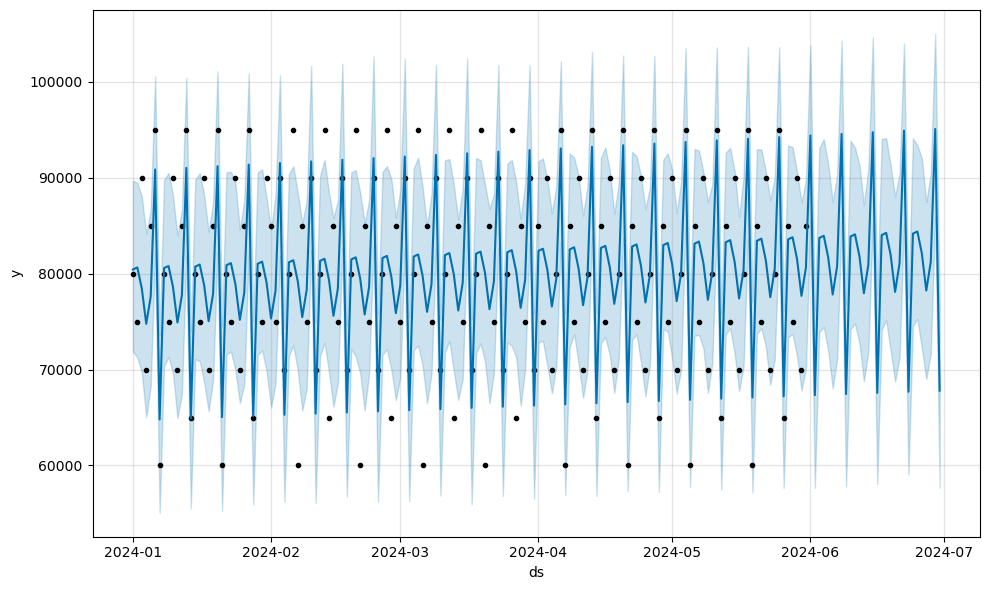

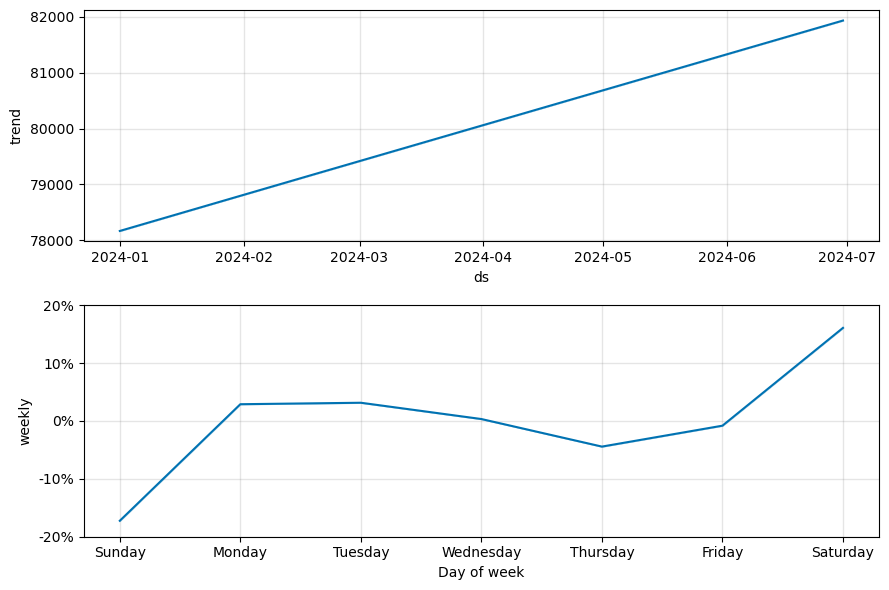

In [217]:
best_model.plot(forecast)
plt.show()

best_model.plot_components(forecast)
plt.show()

235198728.06601253


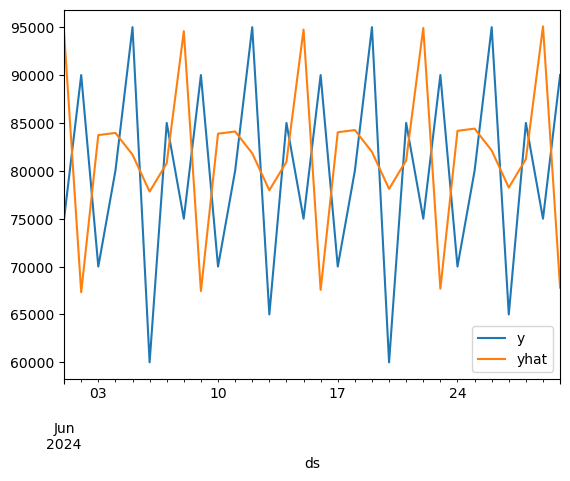

In [218]:
df_luar_test.plot()
print(mean_squared_error(df_luar_test["y"], df_luar_test["yhat"]))

In [219]:
df_luar_test.isna().sum()

y       0
yhat    0
dtype: int64

In [220]:
saldo_awal = 8730000
saldo_akhir_test = 10155000

temp1 = np.array(df_masuk_test["yhat"])
temp2 = np.array(df_luar_test["yhat"])

print(f"Saldo Awal anda adalah {saldo_awal}, dengan saldo akhir (true) adalah {saldo_akhir_test}")
for i in range(len(temp1)):
    saldo_awal = saldo_awal + temp1[i] - temp2[i]

print(f"saldo akhir prediksi anda adalah {round(saldo_awal)}, dengan error sebesar {round(abs(saldo_akhir_test - saldo_awal))}")

Saldo Awal anda adalah 8730000, dengan saldo akhir (true) adalah 10155000
saldo akhir prediksi anda adalah 10081129, dengan error sebesar 73871


In [221]:
nama_metode.append("prophet")
saldo_akhir.append(round(saldo_awal))
error.append(round(abs(saldo_akhir_test - saldo_awal)))

In [222]:
print(df_masuk_train.columns)
print(df_masuk_test.columns)
print(df_luar_train.columns)
print(df_luar_test.columns)

Index(['ds', 'y'], dtype='object')
Index(['y', 'yhat'], dtype='object')
Index(['ds', 'y'], dtype='object')
Index(['y', 'yhat'], dtype='object')


In [223]:
df_masuk_train.set_index("ds", inplace=True)
df_luar_train.set_index("ds", inplace=True)

## Using LSTM

### Pemasukan

In [226]:
df_masuk_test.drop(columns="yhat", inplace = True)
sc = MinMaxScaler()
train_transform = sc.fit_transform(df_masuk_train)
test_tranform = sc.transform(df_masuk_test)

In [227]:
df_masuk_train

,y
ds,
2024-01-01,120000
2024-01-02,135000
2024-01-03,110000
2024-01-04,145000
2024-01-05,130000
...,...
2024-05-27,145000
2024-05-28,125000
2024-05-29,135000


In [228]:
n_input = 35
n_features = 1

generator = TimeseriesGenerator(train_transform, train_transform, length = n_input, batch_size = 1)

In [229]:
rnn = Sequential()

rnn.add(LSTM(units = 10, activation = "relu", return_sequences = True, input_shape = (n_input, n_features)))

rnn.add(LSTM(units = 10, activation = "relu"))

rnn.add(Dense(units = 1))

rnn.compile(optimizer = "adam", loss = "mse")

In [230]:
rnn.fit(generator, epochs=100)

Epoch 1/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 35s 28ms/step - loss: 0.2009
Epoch 2/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1027
Epoch 3/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.1040
Epoch 4/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0915
Epoch 5/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0982
Epoch 6/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0918
Epoch 7/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0929
Epoch 8/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0957
Epoch 9/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0784
Epoch 10/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0863
Epoch 11/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0889
Epoch 12/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0802
Epoch 13/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0917
Epoch 14/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0842
Epoch 15/100
117/117 ━━━━━━━

In [231]:
test_prediction = []

first_eval_batch = train_transform[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(df_masuk_test)):
    current_pred = rnn.predict(current_batch)[0]
    test_prediction.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis = 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━

In [232]:
hasil_akhir = []

for i in range(len(test_prediction)):
    hasil_akhir.append(test_prediction[i][0])

hasil_akhir = np.array(hasil_akhir)
hasil_akhir = hasil_akhir.reshape(-1,1)

hasil_akhir = sc.inverse_transform(hasil_akhir)
hasil_akhir = hasil_akhir.reshape(-1)

In [233]:
df_masuk_test["yhat"] = hasil_akhir

<Axes: xlabel='ds'>

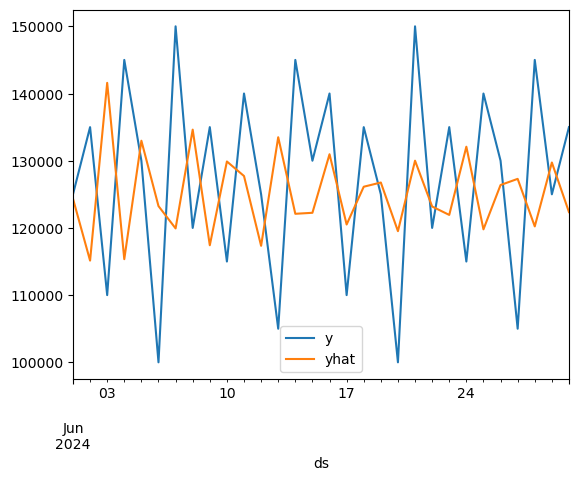

In [234]:
df_masuk_test.plot()

### Pengeluaran

In [236]:
df_luar_test.drop(columns="yhat", inplace = True)
sc = MinMaxScaler()
train_transform = sc.fit_transform(df_luar_train)
test_tranform = sc.transform(df_luar_test)

In [237]:
n_input = 35
n_features = 1

generator = TimeseriesGenerator(train_transform, train_transform, length = n_input, batch_size = 1)

In [238]:
rnn = Sequential()

rnn.add(LSTM(units = 75, activation = "relu", return_sequences = True, input_shape = (n_input, n_features)))

rnn.add(LSTM(units = 75, activation = "relu"))

rnn.add(Dense(units = 1))

rnn.compile(optimizer = "adam", loss = "mse")

In [239]:
rnn.fit(generator, epochs=5)

Epoch 1/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - loss: 0.1786
Epoch 2/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.1187
Epoch 3/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.1061
Epoch 4/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0876
Epoch 5/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.1056


In [240]:
test_prediction = []

first_eval_batch = train_transform[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(df_masuk_test)):
    current_pred = rnn.predict(current_batch)[0]
    test_prediction.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis = 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 926ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━

In [241]:
hasil_akhir = []

for i in range(len(test_prediction)):
    hasil_akhir.append(test_prediction[i][0])

hasil_akhir = np.array(hasil_akhir)
hasil_akhir = hasil_akhir.reshape(-1,1)

hasil_akhir = sc.inverse_transform(hasil_akhir)
hasil_akhir = hasil_akhir.reshape(-1)

In [242]:
print(hasil_akhir)

[80710.23  80739.62  80770.08  80796.69  80822.68  80845.27  80868.39
 80888.63  80905.81  80925.164 80940.336 80955.3   80967.43  80980.63
 80991.63  81000.25  81011.086 81018.93  81027.1   81033.05  81040.51
 81046.28  81050.195 81057.055 81060.95  81065.48  81068.21  81072.62
 81075.71  81077.27 ]


In [243]:
df_luar_test["yhat"] = hasil_akhir

In [244]:
rmse = np.sqrt(np.mean((df_luar_test["yhat"] - df_luar_test["y"])**2))
print(f'RMSE: {rmse}')

RMSE: 10504.622342657887


<Axes: xlabel='ds'>

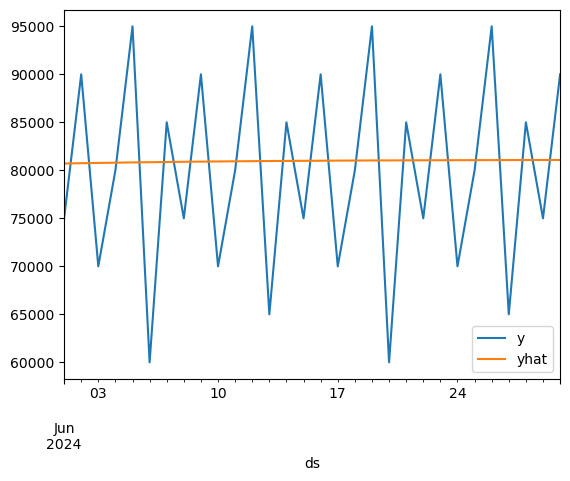

In [245]:
df_luar_test.plot()

In [246]:
saldo_awal = 8730000
saldo_akhir_test = 10155000

temp1 = np.array(df_masuk_test["yhat"])
temp2 = np.array(df_luar_test["yhat"])

print(f"Saldo Awal anda adalah {saldo_awal}, dengan saldo akhir (true) adalah {saldo_akhir_test}")
for i in range(len(temp1)):
    saldo_awal = saldo_awal + temp1[i] - temp2[i]

print(f"saldo akhir prediksi anda adalah {round(saldo_awal)}, dengan error sebesar {round(abs(saldo_akhir_test - saldo_awal))}")

Saldo Awal anda adalah 8730000, dengan saldo akhir (true) adalah 10155000
saldo akhir prediksi anda adalah 10055481, dengan error sebesar 99519


In [247]:
nama_metode.append("LSTM")
saldo_akhir.append(round(saldo_awal))
error.append(round(abs(saldo_akhir_test - saldo_awal)))

## Random Forest

### Pemasukan

89262166.66666667


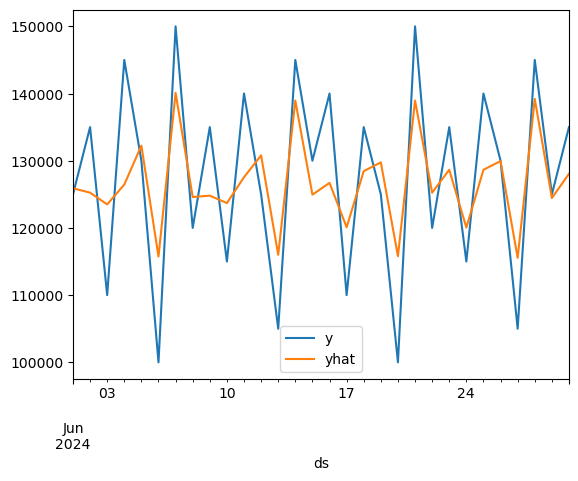

In [250]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Assume df_masuk_train is your DataFrame
# df_masuk_train = pd.DataFrame({'y': np.random.rand(170)})  # Example DataFrame

# Set parameters
timesteps = 35  # number of input steps
n_forecast_days = 30  # number of days to predict
data_length_train = len(df_masuk_train)  # length of training signal

# Create dataset for training
X_train = []
y_train = []

# Create input-output sequence for training
for i in range(data_length_train - timesteps - n_forecast_days + 1):
    X_train.append(df_masuk_train['y'].iloc[i:i + timesteps].values)
    y_train.append(df_masuk_train['y'].iloc[i + timesteps:i + timesteps + n_forecast_days].values)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Train Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions for 30 days ahead
last_input = df_masuk_train['y'].iloc[-timesteps:].values.reshape(1, -1)
y_pred = []

for _ in range(n_forecast_days):
    pred = model.predict(last_input)[0]  # predict next day
    y_pred.append(pred[0])  # store prediction
    last_input = np.roll(last_input, -1)  # shift input
    last_input[0, -1] = pred[0]  # insert prediction into input

# Display results
df_masuk_test['yhat'] = y_pred

df_masuk_test.plot()
print(mean_squared_error(df_masuk_test["y"], df_masuk_test["yhat"]))


### Pengeluaran

160734712.4537037


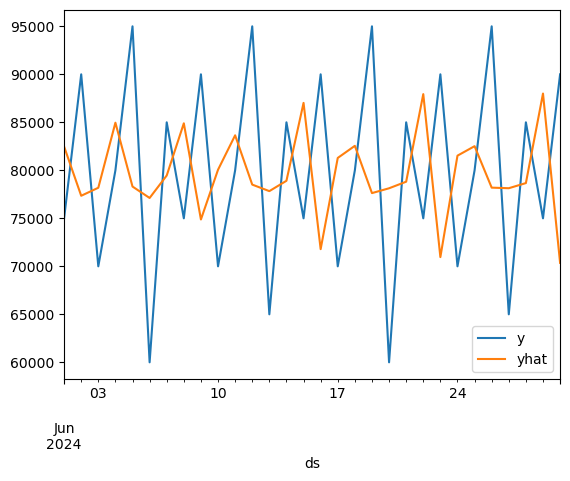

In [252]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Assume df_luar_train is your DataFrame
# df_luar_train = pd.DataFrame({'y': np.random.rand(170)})  # Example DataFrame

# Set parameters
timesteps = 14  # number of input steps
n_forecast_days = 30  # number of days to predict
data_length_train = len(df_luar_train)  # length of training signal

# Create dataset for training
X_train = []
y_train = []

# Create input-output sequence for training
for i in range(data_length_train - timesteps - n_forecast_days + 1):
    X_train.append(df_luar_train['y'].iloc[i:i + timesteps].values)
    y_train.append(df_luar_train['y'].iloc[i + timesteps:i + timesteps + n_forecast_days].values)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Train Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions for 30 days ahead
last_input = df_luar_train['y'].iloc[-timesteps:].values.reshape(1, -1)
y_pred = []

for _ in range(n_forecast_days):
    pred = model.predict(last_input)[0]  # predict next day
    y_pred.append(pred[0])  # store prediction
    last_input = np.roll(last_input, -1)  # shift input
    last_input[0, -1] = pred[0]  # insert prediction into input

# Display results
df_luar_test['yhat'] = pred

df_luar_test.plot()
print(mean_squared_error(df_luar_test["y"], df_luar_test["yhat"]))

In [253]:
saldo_awal = 8730000
saldo_akhir_test = 10155000

temp1 = np.array(df_masuk_test["yhat"])
temp2 = np.array(df_luar_test["yhat"])

print(f"Saldo Awal anda adalah {saldo_awal}, dengan saldo akhir (true) adalah {saldo_akhir_test}")
for i in range(len(temp1)):
    saldo_awal = saldo_awal + temp1[i] - temp2[i]

print(f"saldo akhir prediksi anda adalah {saldo_awal}, dengan error sebesar {abs(saldo_akhir_test - saldo_awal)}")

Saldo Awal anda adalah 8730000, dengan saldo akhir (true) adalah 10155000
saldo akhir prediksi anda adalah 10139974.999999998, dengan error sebesar 15025.000000001863


In [254]:
nama_metode.append("Random Forest")
saldo_akhir.append(round(saldo_awal))
error.append(round(abs(saldo_akhir_test - saldo_awal)))

## SVR

### Pemasukan

Best parameters: {'C': 0.1, 'epsilon': 0.1, 'kernel': 'linear'}


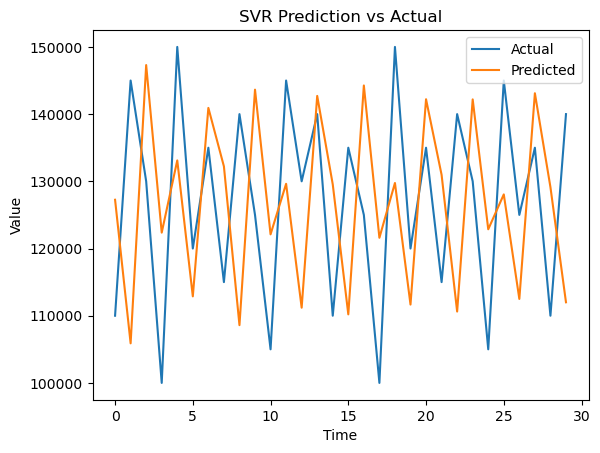

Mean Squared Error: 370978778.65606934


In [257]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Assume df_masuk_train is your DataFrame
# df_masuk_train = pd.DataFrame({'y': np.random.rand(170)})  # Example DataFrame

# Set parameters
timesteps = 35  # number of input steps
n_forecast_days = 30  # number of days to predict
data_length_train = len(df_masuk_train)  # length of training signal

# Create dataset for training
X_train = []
y_train = []

# Create input-output sequence for training
for i in range(data_length_train - timesteps - n_forecast_days + 1):
    X_train.append(df_masuk_train['y'].iloc[i:i + timesteps].values)
    y_train.append(df_masuk_train['y'].iloc[i + timesteps])  # Changed this line

X_train = np.array(X_train)
y_train = np.array(y_train)

# Scale the features
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

# Define parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.2],
    'kernel': ['rbf', 'linear']
}

# Create SVR model
svr = SVR()

# Perform GridSearchCV
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train_scaled)

# Get best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best parameters:", best_params)

# Make predictions for 30 days ahead
last_input = df_masuk_train['y'].iloc[-timesteps:].values.reshape(1, -1)
last_input_scaled = scaler_X.transform(last_input)
y_pred = []

for _ in range(n_forecast_days):
    pred_scaled = best_model.predict(last_input_scaled).reshape(1, -1)  # predict next day
    pred = scaler_y.inverse_transform(pred_scaled)  # scale back to original range
    y_pred.append(pred[0, 0])  # store prediction
    last_input_scaled = np.roll(last_input_scaled, -1)  # shift input
    last_input_scaled[0, -1] = pred_scaled[0, 0]  # insert prediction into input

# Display results
df_masuk_test = pd.DataFrame({'y': df_masuk_train['y'].iloc[-n_forecast_days:].values})
df_masuk_test['yhat'] = y_pred
df_masuk_test.plot()
plt.title('SVR Prediction vs Actual')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Actual', 'Predicted'])
plt.show()

# Calculate and print MSE
mse = mean_squared_error(df_masuk_test['y'], df_masuk_test['yhat'])
print(f"Mean Squared Error: {mse}")

### Pengeluaran

Best parameters: {'C': 1, 'epsilon': 0.1, 'kernel': 'linear'}


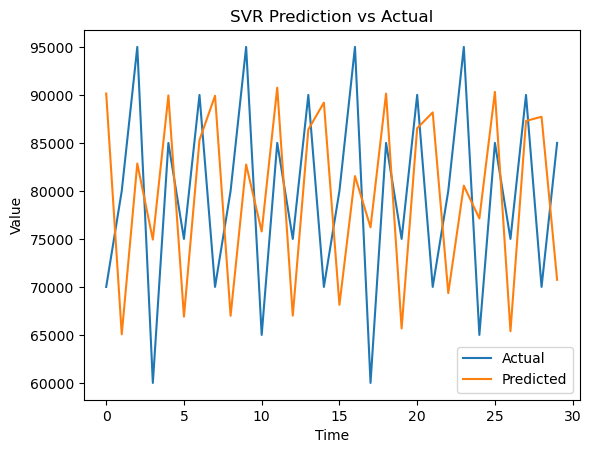

Mean Squared Error: 152563215.94156644


In [259]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Assume df_luar_train is your DataFrame
# df_luar_train = pd.DataFrame({'y': np.random.rand(170)})  # Example DataFrame

# Set parameters
timesteps = 14  # number of input steps
n_forecast_days = 30  # number of days to predict
data_length_train = len(df_luar_train)  # length of training signal

# Create dataset for training
X_train = []
y_train = []

# Create input-output sequence for training
for i in range(data_length_train - timesteps - n_forecast_days + 1):
    X_train.append(df_luar_train['y'].iloc[i:i + timesteps].values)
    y_train.append(df_luar_train['y'].iloc[i + timesteps])  # Changed this line

X_train = np.array(X_train)
y_train = np.array(y_train)

# Scale the features
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

# Define parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.2],
    'kernel': ['rbf', 'linear']
}

# Create SVR model
svr = SVR()

# Perform GridSearchCV
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train_scaled)

# Get best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best parameters:", best_params)

# Make predictions for 30 days ahead
last_input = df_luar_train['y'].iloc[-timesteps:].values.reshape(1, -1)
last_input_scaled = scaler_X.transform(last_input)
y_pred = []

for _ in range(n_forecast_days):
    pred_scaled = best_model.predict(last_input_scaled).reshape(1, -1)  # predict next day
    pred = scaler_y.inverse_transform(pred_scaled)  # scale back to original range
    y_pred.append(pred[0, 0])  # store prediction
    last_input_scaled = np.roll(last_input_scaled, -1)  # shift input
    last_input_scaled[0, -1] = pred_scaled[0, 0]  # insert prediction into input

# Display results
df_luar_test = pd.DataFrame({'y': df_luar_train['y'].iloc[-n_forecast_days:].values})
df_luar_test['yhat'] = y_pred
df_luar_test.plot()
plt.title('SVR Prediction vs Actual')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Actual', 'Predicted'])
plt.show()

# Calculate and print MSE
mse = mean_squared_error(df_luar_test['y'], df_luar_test['yhat'])
print(f"Mean Squared Error: {mse}")

In [260]:
saldo_awal = 8730000
saldo_akhir_test = 10155000

temp1 = np.array(df_masuk_test["yhat"])
temp2 = np.array(df_luar_test["yhat"])

print(f"Saldo Awal anda adalah {saldo_awal}, dengan saldo akhir (true) adalah {saldo_akhir_test}")
for i in range(len(temp1)):
    saldo_awal = saldo_awal + temp1[i] - temp2[i]

print(f"saldo akhir prediksi anda adalah {saldo_awal}, dengan error sebesar {abs(saldo_akhir_test - saldo_awal)}")

Saldo Awal anda adalah 8730000, dengan saldo akhir (true) adalah 10155000
saldo akhir prediksi anda adalah 10141639.718135051, dengan error sebesar 13360.28186494857


In [261]:
nama_metode.append("SVR")
saldo_akhir.append(round(saldo_awal))
error.append(round(abs(saldo_akhir_test - saldo_awal)))

## MLP sklearn

### Pemasukan

348615872.1876586


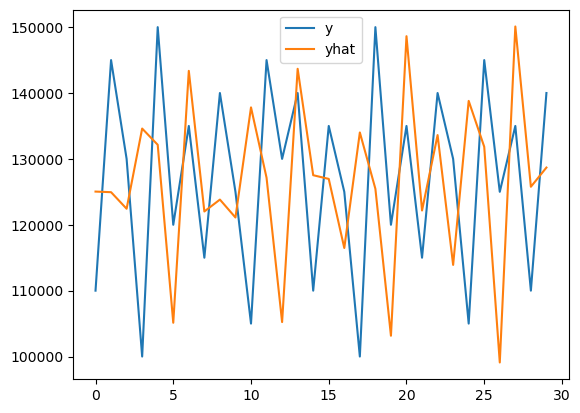

In [264]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Set parameters
timesteps = 35  # number of input steps
n_forecast_days = 30  # number of days to predict
data_length_train = len(df_masuk_train)  # length of training signal

# Create dataset for training
X_train = []
y_train = []

# Create input-output sequence for training
for i in range(data_length_train - timesteps - n_forecast_days + 1):
    X_train.append(df_masuk_train['y'].iloc[i:i + timesteps].values)
    y_train.append(df_masuk_train['y'].iloc[i + timesteps:i + timesteps + n_forecast_days].values)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Scale the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)

# Train MLP model
model = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', 
                     max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train_scaled)

# Make predictions for 30 days ahead
last_input = df_masuk_train['y'].iloc[-timesteps:].values.reshape(1, -1)
last_input_scaled = scaler_X.transform(last_input)
y_pred_scaled = []

for _ in range(n_forecast_days):
    pred_scaled = model.predict(last_input_scaled)[0]
    y_pred_scaled.append(pred_scaled[0])
    last_input_scaled = np.roll(last_input_scaled, -1)
    last_input_scaled[0, -1] = pred_scaled[0]

# Inverse transform the predictions
y_pred = scaler_y.inverse_transform(np.array(y_pred_scaled).reshape(-1, n_forecast_days))[0]

# Display results
df_masuk_test['yhat'] = y_pred

df_masuk_test.plot()
print(mean_squared_error(df_masuk_test["y"], df_masuk_test["yhat"]))


### Pengeluaran

159477186.87689564


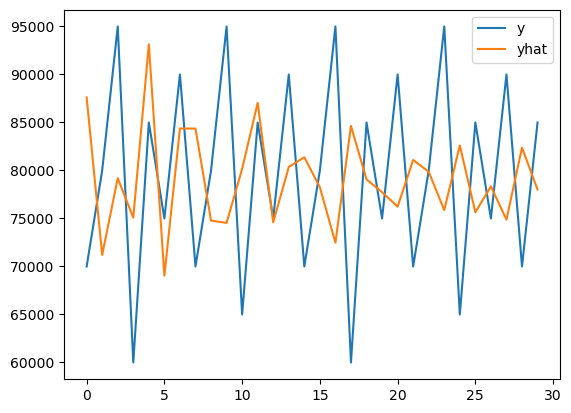

In [266]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

# Assume df_luar_train is your DataFrame
# df_luar_train = pd.DataFrame({'y': np.random.rand(170)})  # Example DataFrame

# Set parameters
timesteps = 14  # number of input steps
n_forecast_days = 30  # number of days to predict
data_length_train = len(df_luar_train)  # length of training signal

# Create dataset for training
X_train = []
y_train = []

# Create input-output sequence for training
for i in range(data_length_train - timesteps - n_forecast_days + 1):
    X_train.append(df_luar_train['y'].iloc[i:i + timesteps].values)
    y_train.append(df_luar_train['y'].iloc[i + timesteps:i + timesteps + n_forecast_days].values)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Scale the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)

# Train MLP model
model = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', 
                     max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train_scaled)

# Make predictions for 30 days ahead
last_input = df_luar_train['y'].iloc[-timesteps:].values.reshape(1, -1)
last_input_scaled = scaler_X.transform(last_input)
y_pred_scaled = []

for _ in range(n_forecast_days):
    pred_scaled = model.predict(last_input_scaled)[0]
    y_pred_scaled.append(pred_scaled[0])
    last_input_scaled = np.roll(last_input_scaled, -1)
    last_input_scaled[0, -1] = pred_scaled[0]

# Inverse transform the predictions
y_pred = scaler_y.inverse_transform(np.array(y_pred_scaled).reshape(-1, n_forecast_days))[0]

# Display results
df_luar_test['yhat'] = y_pred

df_luar_test.plot()
print(mean_squared_error(df_luar_test["y"], df_luar_test["yhat"]))

In [267]:
saldo_awal = 8730000
saldo_akhir_test = 10155000

temp1 = np.array(df_masuk_test["yhat"])
temp2 = np.array(df_luar_test["yhat"])

print(f"Saldo Awal anda adalah {saldo_awal}, dengan saldo akhir (true) adalah {saldo_akhir_test}")
for i in range(len(temp1)):
    saldo_awal = saldo_awal + temp1[i] - temp2[i]

print(f"saldo akhir prediksi anda adalah {saldo_awal}, dengan error sebesar {abs(saldo_akhir_test - saldo_awal)}")

Saldo Awal anda adalah 8730000, dengan saldo akhir (true) adalah 10155000
saldo akhir prediksi anda adalah 10150682.636621527, dengan error sebesar 4317.363378472626


In [268]:
nama_metode.append("MLP Sklearn")
saldo_akhir.append(round(saldo_awal))
error.append(round(abs(saldo_akhir_test - saldo_awal)))

## MLP Keras

### Pemasukan

In [271]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

# Set parameters
timesteps = 35  # number of input steps
n_forecast_days = 30  # number of days to predict
data_length_train = len(df_masuk_train)  # length of training signal

# Create dataset for training
X_train = []
y_train = []

# Create input-output sequence for training
for i in range(data_length_train - timesteps - n_forecast_days + 1):
    X_train.append(df_masuk_train['y'].iloc[i:i + timesteps].values)
    y_train.append(df_masuk_train['y'].iloc[i + timesteps:i + timesteps + n_forecast_days].values)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Scale the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)

# Build the Keras MLP model
model = Sequential([
    Dense(75, activation='relu', input_shape=(timesteps,)),
    Dense(75, activation='relu'),
    Dense(75, activation='relu'),
    Dense(n_forecast_days)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
history = model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Make predictions for 30 days ahead
last_input = df_masuk_train['y'].iloc[-timesteps:].values.reshape(1, -1)
last_input_scaled = scaler_X.transform(last_input)
y_pred_scaled = []

for _ in range(n_forecast_days):
    pred_scaled = model.predict(last_input_scaled)
    y_pred_scaled.append(pred_scaled[0])
    last_input_scaled = np.roll(last_input_scaled, -1, axis=1)
    last_input_scaled[0, -1] = pred_scaled[0, 0]

# Inverse transform the predictions
y_pred = scaler_y.inverse_transform(np.array(y_pred_scaled))[0]

# Display the predicted values (if required)
df_masuk_test['yhat'] = y_pred

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 263ms/step - loss: 1.0791 - val_loss: 1.0305
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1.0079 - val_loss: 0.9906
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.9601 - val_loss: 0.9591
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.9307 - val_loss: 0.9334
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.9059 - val_loss: 0.9110
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.8870 - val_loss: 0.8882
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.8571 - val_loss: 0.8609
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.8244 - val_loss: 0.8316
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.8094 - val_loss: 0.8008
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.7706 - val_loss: 0.7675
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.7464 - val_loss: 0.7317
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.7107 - val_l

159477186.87689564


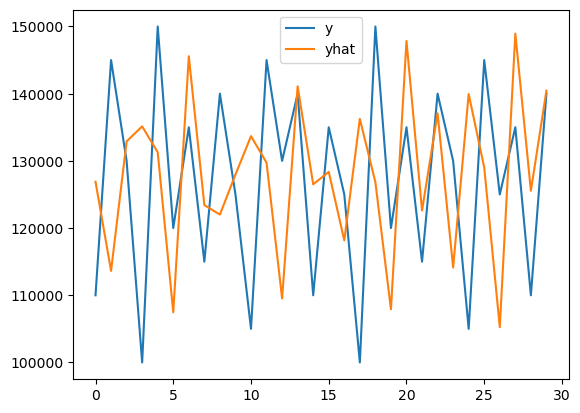

In [272]:
# Plotting results (if required)
df_masuk_test.plot()

print(mean_squared_error(df_luar_test["y"], df_luar_test["yhat"]))

### Pengeluaran

In [274]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

# Assume df_luar_train is your DataFrame
# df_luar_train = pd.DataFrame({'y': np.random.rand(170)})  # Example DataFrame

# Set parameters
timesteps = 14  # number of input steps
n_forecast_days = 30  # number of days to predict
data_length_train = len(df_luar_train)  # length of training signal

# Create dataset for training
X_train = []
y_train = []

# Create input-output sequence for training
for i in range(data_length_train - timesteps - n_forecast_days + 1):
    X_train.append(df_luar_train['y'].iloc[i:i + timesteps].values)
    y_train.append(df_luar_train['y'].iloc[i + timesteps:i + timesteps + n_forecast_days].values)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Scale the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)

# Build the Keras MLP model
model = Sequential([
    Dense(75, activation='relu', input_shape=(timesteps,)),
    Dense(75, activation='relu'),
    Dense(75, activation='relu'),
    Dense(n_forecast_days)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
history = model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Make predictions for 30 days ahead
last_input = df_luar_train['y'].iloc[-timesteps:].values.reshape(1, -1)
last_input_scaled = scaler_X.transform(last_input)
y_pred_scaled = []

for _ in range(n_forecast_days):
    pred_scaled = model.predict(last_input_scaled)
    y_pred_scaled.append(pred_scaled[0])
    last_input_scaled = np.roll(last_input_scaled, -1, axis=1)
    last_input_scaled[0, -1] = pred_scaled[0, 0]

# Inverse transform the predictions
y_pred = scaler_y.inverse_transform(np.array(y_pred_scaled))[0]

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 348ms/step - loss: 1.0356 - val_loss: 1.0135
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.9948 - val_loss: 0.9626
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.9492 - val_loss: 0.9199
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.9198 - val_loss: 0.8794
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.8962 - val_loss: 0.8391
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.8701 - val_loss: 0.7989
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.8469 - val_loss: 0.7566
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.8156 - val_loss: 0.7114
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.7883 - val_loss: 0.6661
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.7520 - val_loss: 0.6191
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.7424 - val_loss: 0.5746
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.7040 - val_

117349814.83386637


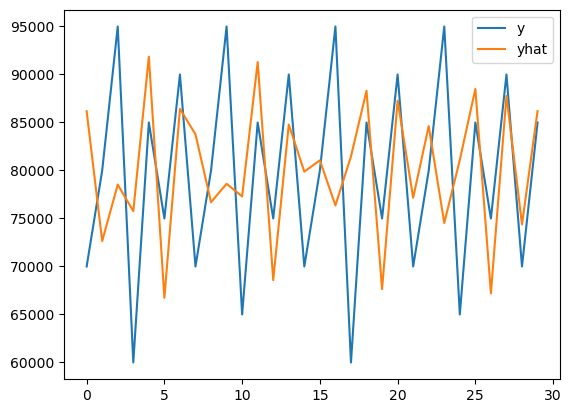

In [275]:
# Display results
df_luar_test['yhat'] = y_pred

df_luar_test.plot()
print(mean_squared_error(df_luar_test["y"], df_luar_test["yhat"]))

In [276]:
saldo_awal = 8730000
saldo_akhir_test = 10155000

temp1 = np.array(df_masuk_test["yhat"])
temp2 = np.array(df_luar_test["yhat"])

print(f"Saldo Awal anda adalah {saldo_awal}, dengan saldo akhir (true) adalah {saldo_akhir_test}")
for i in range(len(temp1)):
    saldo_awal = saldo_awal + temp1[i] - temp2[i]

print(f"saldo akhir prediksi anda adalah {saldo_awal}, dengan error sebesar {abs(saldo_akhir_test - saldo_awal)}")

Saldo Awal anda adalah 8730000, dengan saldo akhir (true) adalah 10155000
saldo akhir prediksi anda adalah 10162553.828125, dengan error sebesar 7553.828125


In [277]:
nama_metode.append("MLP Keras")
saldo_akhir.append(round(saldo_awal))
error.append(round(abs(saldo_akhir_test - saldo_awal)))

## XGBoost

### Pemasukan

Predictions for the next 30 days: [125452.9   133907.47  111347.07  143987.77  130965.52  101204.25
 149551.94  120527.56  132859.44  117273.37  138043.42  126578.266
 105907.22  144233.78  129169.44  136754.95  112754.83  133145.31
 125519.17  102423.43  148444.72  122520.95  132672.84  117835.766
 138009.3   130560.1   106351.05  143872.73  125244.57  134639.36 ]
356499902.182843


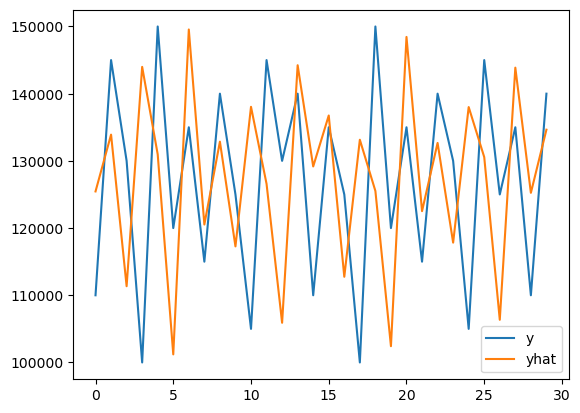

In [280]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Set parameters
timesteps = 14  # number of input steps
n_forecast_days = 30  # number of days to predict
data_length_train = len(df_masuk_train)  # length of training signal

# Create dataset for training
X_train = []
y_train = []

# Create input-output sequence for training
for i in range(data_length_train - timesteps - n_forecast_days + 1):
    X_train.append(df_masuk_train['y'].iloc[i:i + timesteps].values)
    y_train.append(df_masuk_train['y'].iloc[i + timesteps:i + timesteps + n_forecast_days].values)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Scale the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)

# Train XGBoost model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train_scaled, y_train_scaled)

# Make predictions for 30 days ahead
last_input = df_masuk_train['y'].iloc[-timesteps:].values.reshape(1, -1)
last_input_scaled = scaler_X.transform(last_input)
y_pred_scaled = []

for _ in range(n_forecast_days):
    pred_scaled = model.predict(last_input_scaled).reshape(1, -1)
    y_pred_scaled.append(pred_scaled[0])
    last_input_scaled = np.roll(last_input_scaled, -1)
    last_input_scaled[0, -1] = pred_scaled[0, 0]

# Inverse transform the predictions
y_pred = scaler_y.inverse_transform(np.array(y_pred_scaled))[0]

# Display results
print("Predictions for the next 30 days:", y_pred)

# Plot prediction results
df_masuk_test['yhat'] = y_pred

df_masuk_test.plot()
print(mean_squared_error(df_masuk_test["y"], df_masuk_test["yhat"]))

### Pengeluaran

Predictions for the next 30 days: [75135.38  89778.32  70283.58  79815.39  94749.625 60301.258 84921.47
 75465.87  89676.484 70874.11  79758.414 94625.805 65288.344 84792.76
 75226.18  89688.7   70224.836 79991.28  94495.82  60227.91  84762.21
 75197.48  89817.82  70375.69  79804.414 94624.25  65212.863 84761.41
 75283.73  89843.875]
176217942.33690083


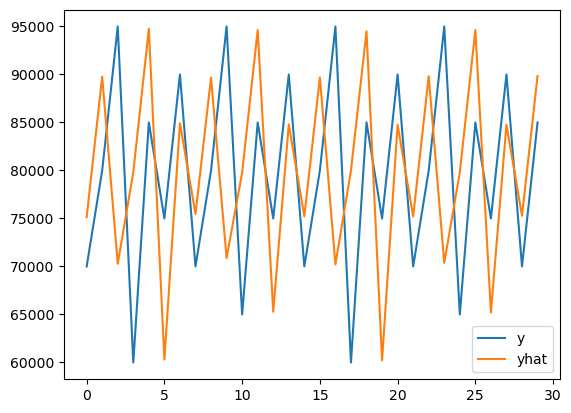

In [282]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler

# Assume df_luar_train is your DataFrame
# df_luar_train = pd.DataFrame({'y': np.random.rand(170)})  # Example DataFrame

# Set parameters
timesteps = 14  # number of input steps
n_forecast_days = 30  # number of days to predict
data_length_train = len(df_luar_train)  # length of training signal

# Create dataset for training
X_train = []
y_train = []

# Create input-output sequence for training
for i in range(data_length_train - timesteps - n_forecast_days + 1):
    X_train.append(df_luar_train['y'].iloc[i:i + timesteps].values)
    y_train.append(df_luar_train['y'].iloc[i + timesteps:i + timesteps + n_forecast_days].values)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Scale the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)

# Train XGBoost model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train_scaled, y_train_scaled)

# Make predictions for 30 days ahead
last_input = df_luar_train['y'].iloc[-timesteps:].values.reshape(1, -1)
last_input_scaled = scaler_X.transform(last_input)
y_pred_scaled = []

for _ in range(n_forecast_days):
    pred_scaled = model.predict(last_input_scaled).reshape(1, -1)
    y_pred_scaled.append(pred_scaled[0])
    last_input_scaled = np.roll(last_input_scaled, -1)
    last_input_scaled[0, -1] = pred_scaled[0, 0]

# Inverse transform the predictions
y_pred = scaler_y.inverse_transform(np.array(y_pred_scaled))[0]

# Display results
print("Predictions for the next 30 days:", y_pred)

# Plot prediction results
df_luar_test['yhat'] = y_pred

df_luar_test.plot()
print(mean_squared_error(df_luar_test["y"], df_luar_test["yhat"]))

In [283]:
saldo_awal = 8730000
saldo_akhir_test = 10155000

temp1 = np.array(df_masuk_test["yhat"])
temp2 = np.array(df_luar_test["yhat"])

print(f"Saldo Awal anda adalah {saldo_awal}, dengan saldo akhir (true) adalah {saldo_akhir_test}")
for i in range(len(temp1)):
    saldo_awal = saldo_awal + temp1[i] - temp2[i]

print(f"saldo akhir prediksi anda adalah {saldo_awal}, dengan error sebesar {abs(saldo_akhir_test - saldo_awal)}")

Saldo Awal anda adalah 8730000, dengan saldo akhir (true) adalah 10155000
saldo akhir prediksi anda adalah 10156753.2265625, dengan error sebesar 1753.2265625


In [284]:
nama_metode.append("XGBoost")
saldo_akhir.append(round(saldo_awal))
error.append(round(abs(saldo_akhir_test - saldo_awal)))

## Arima

### Pemasukan

ARIMA(0, 0, 0) RMSE=14802.020
ARIMA(0, 0, 1) RMSE=9591.921
ARIMA(0, 0, 2) RMSE=9311.506
ARIMA(0, 0, 3) RMSE=9682.070
ARIMA(0, 1, 0) RMSE=26350.614
ARIMA(0, 1, 1) RMSE=14828.491
ARIMA(0, 1, 2) RMSE=9351.265
ARIMA(0, 1, 3) RMSE=12539.050
ARIMA(0, 2, 0) RMSE=48593.110
ARIMA(0, 2, 1) RMSE=26472.877
ARIMA(0, 2, 2) RMSE=17504.974
ARIMA(0, 2, 3) RMSE=17829.879
ARIMA(1, 0, 0) RMSE=11696.392
ARIMA(1, 0, 1) RMSE=9324.357
ARIMA(1, 0, 2) RMSE=9589.158
ARIMA(1, 0, 3) RMSE=9019.141
ARIMA(1, 1, 0) RMSE=18573.562
ARIMA(1, 1, 1) RMSE=12006.383
ARIMA(1, 1, 2) RMSE=9331.486
ARIMA(1, 1, 3) RMSE=9308.129
ARIMA(1, 2, 0) RMSE=30512.222
ARIMA(1, 2, 1) RMSE=19044.635
ARIMA(1, 2, 2) RMSE=16561.239
ARIMA(1, 2, 3) RMSE=16490.802
ARIMA(2, 0, 0) RMSE=10733.265
ARIMA(2, 0, 1) RMSE=9401.215
ARIMA(2, 0, 2) RMSE=8599.552
ARIMA(2, 0, 3) RMSE=9279.915
ARIMA(2, 1, 0) RMSE=15707.157
ARIMA(2, 1, 1) RMSE=10890.087
ARIMA(2, 1, 2) RMSE=10565.024
ARIMA(2, 1, 3) RMSE=8727.704
ARIMA(2, 2, 0) RMSE=24577.845
ARIMA(2, 2, 1) RMSE=169

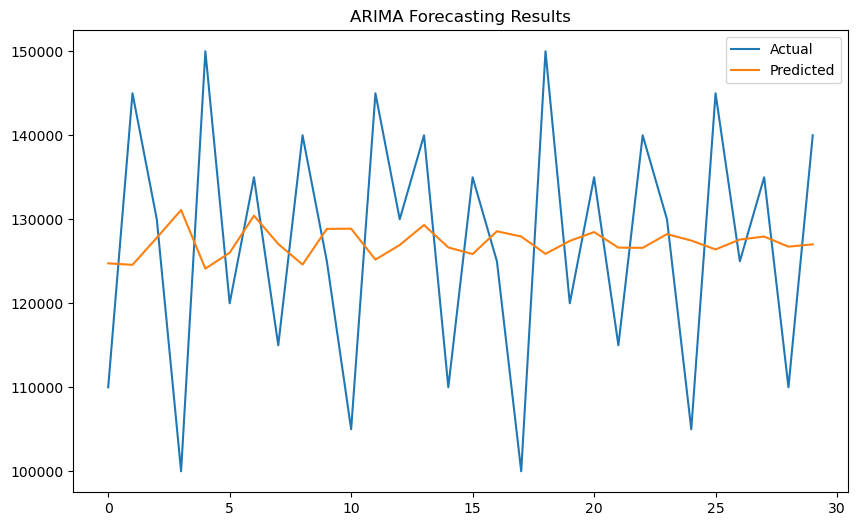

In [287]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from itertools import product

# Function to evaluate ARIMA model
def evaluate_arima_model(X, arima_order):
    # Prepare training dataset
    train_size = int(len(X) * 0.8)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # Make predictions
    predictions = []
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test, predictions))
    return rmse

# Function to perform grid search for ARIMA parameters
def grid_search_arima(X, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p, d, q in product(p_values, d_values, q_values):
        order = (p, d, q)
        try:
            rmse = evaluate_arima_model(X, order)
            if rmse < best_score:
                best_score, best_cfg = rmse, order
            print(f'ARIMA{order} RMSE={rmse:.3f}')
        except:
            continue
    print(f'Best ARIMA{best_cfg} RMSE={best_score:.3f}')
    return best_cfg

# Prepare the data
train_data = df_masuk_train['y'].values
test_data = df_masuk_test['y'].values

# Define the parameter grid
p_values = [0, 1, 2, 3]
d_values = [0, 1, 2]
q_values = [0, 1, 2, 3]

# Perform grid search
best_order = grid_search_arima(train_data, p_values, d_values, q_values)

# Fit the ARIMA model with the best parameters
model = ARIMA(train_data, order=best_order)
model_fit = model.fit()

# Make predictions
predictions1 = model_fit.forecast(steps=len(test_data))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_data, predictions1))
print(f'Test RMSE: {rmse:.3f}')

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(test_data, label='Actual')
plt.plot(predictions1, label='Predicted')
plt.legend()
plt.title('ARIMA Forecasting Results')
plt.show()

### Peneluaran

ARIMA(0, 0, 0) RMSE=10472.210
ARIMA(0, 0, 1) RMSE=6310.140
ARIMA(0, 0, 2) RMSE=5434.416
ARIMA(0, 0, 3) RMSE=5264.284
ARIMA(0, 1, 0) RMSE=19134.498
ARIMA(0, 1, 1) RMSE=10494.429
ARIMA(0, 1, 2) RMSE=6426.804
ARIMA(0, 1, 3) RMSE=6136.604
ARIMA(0, 2, 0) RMSE=35774.833
ARIMA(0, 2, 1) RMSE=19203.699
ARIMA(0, 2, 2) RMSE=11716.424
ARIMA(0, 2, 3) RMSE=11142.192
ARIMA(1, 0, 0) RMSE=7695.480
ARIMA(1, 0, 1) RMSE=5622.549
ARIMA(1, 0, 2) RMSE=5523.027
ARIMA(1, 0, 3) RMSE=5130.409
ARIMA(1, 1, 0) RMSE=12697.228
ARIMA(1, 1, 1) RMSE=7875.542
ARIMA(1, 1, 2) RMSE=5992.575
ARIMA(1, 1, 3) RMSE=6198.722
ARIMA(1, 2, 0) RMSE=21280.305
ARIMA(1, 2, 1) RMSE=12979.450
ARIMA(1, 2, 2) RMSE=10072.928
ARIMA(1, 2, 3) RMSE=10324.982
ARIMA(2, 0, 0) RMSE=6582.350
ARIMA(2, 0, 1) RMSE=5505.534
ARIMA(2, 0, 2) RMSE=5549.033
ARIMA(2, 0, 3) RMSE=5126.789
ARIMA(2, 1, 0) RMSE=10462.594
ARIMA(2, 1, 1) RMSE=6814.861
ARIMA(2, 1, 2) RMSE=6846.954
ARIMA(2, 1, 3) RMSE=5420.498
ARIMA(2, 2, 0) RMSE=16738.910
ARIMA(2, 2, 1) RMSE=11254.540

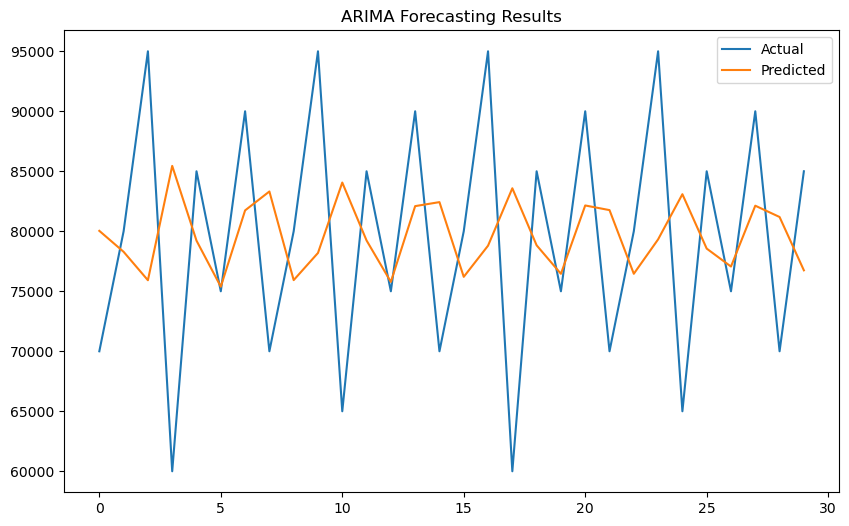

In [289]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from itertools import product

# Assume df_luar_train and df_luar_test are DataFrames with a 'y' column
# If the column name is different, adjust the code below

# Function to evaluate ARIMA model
def evaluate_arima_model(X, arima_order):
    # Prepare training dataset
    train_size = int(len(X) * 0.8)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # Make predictions
    predictions = []
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test, predictions))
    return rmse

# Function to perform grid search for ARIMA parameters
def grid_search_arima(X, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p, d, q in product(p_values, d_values, q_values):
        order = (p, d, q)
        try:
            rmse = evaluate_arima_model(X, order)
            if rmse < best_score:
                best_score, best_cfg = rmse, order
            print(f'ARIMA{order} RMSE={rmse:.3f}')
        except:
            continue
    print(f'Best ARIMA{best_cfg} RMSE={best_score:.3f}')
    return best_cfg

# Prepare the data
train_data = df_luar_train['y'].values
test_data = df_luar_test['y'].values

# Define the parameter grid
p_values = [0, 1, 2, 3]
d_values = [0, 1, 2]
q_values = [0, 1, 2, 3]

# Perform grid search
best_order = grid_search_arima(train_data, p_values, d_values, q_values)

# Fit the ARIMA model with the best parameters
model = ARIMA(train_data, order=best_order)
model_fit = model.fit()

# Make predictions
predictions2 = model_fit.forecast(steps=len(test_data))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_data, predictions2))
print(f'Test RMSE: {rmse:.3f}')

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(test_data, label='Actual')
plt.plot(predictions2, label='Predicted')
plt.legend()
plt.title('ARIMA Forecasting Results')
plt.show()

In [290]:
saldo_awal = 8730000
saldo_akhir_test = 10155000

temp1 = np.array(predictions1)
temp2 = np.array(predictions2)

print(f"Saldo Awal anda adalah {saldo_awal}, dengan saldo akhir (true) adalah {saldo_akhir_test}")
for i in range(len(temp1)):
    saldo_awal = saldo_awal + temp1[i] - temp2[i]

print(f"saldo akhir prediksi anda adalah {saldo_awal}, dengan error sebesar {abs(saldo_akhir_test - saldo_awal)}")

Saldo Awal anda adalah 8730000, dengan saldo akhir (true) adalah 10155000
saldo akhir prediksi anda adalah 10155687.330752907, dengan error sebesar 687.3307529073209


In [291]:
nama_metode.append("Arima")
saldo_akhir.append(round(saldo_awal))
error.append(round(abs(saldo_akhir_test - saldo_awal)))

## Auto Arima

### Pemasukan

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4008.666, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3530.157, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3909.910, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3284.965, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=3351.018, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=3261.674, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=3249.849, Time=0.36 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=3251.564, Time=0.83 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.74 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0] intercept
Total fit time: 3.019 seconds
                               SARIMAX Results 

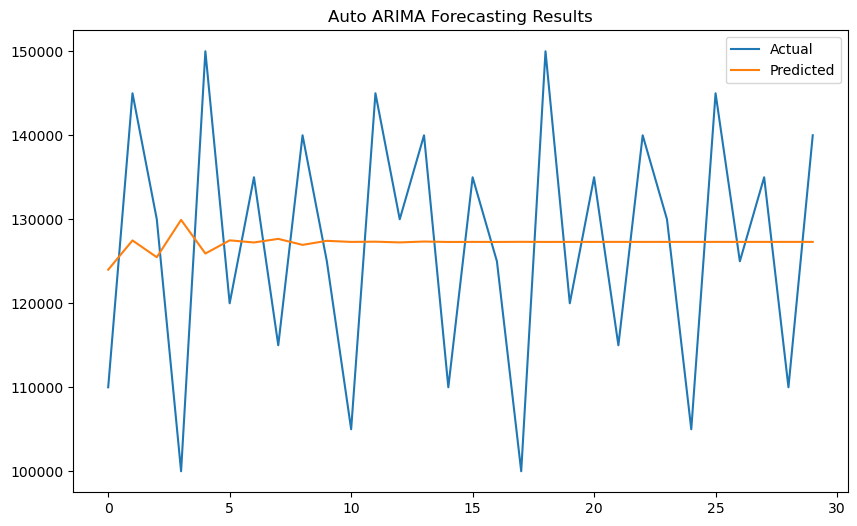

In [294]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error

# Prepare the data
train_data = df_masuk_train['y'].values
test_data = df_masuk_test['y'].values

# Fit auto ARIMA model
model = auto_arima(train_data, 
                   start_p=0, start_q=0, 
                   max_p=3, max_q=3, 
                   m=1,  # Seasonality (for non-seasonal data, set m=1)
                   start_P=0, seasonal=False,  # Set seasonal=False for non-seasonal data
                   d=None,  # Let auto_arima determine the order of differencing
                   trace=True,  # Print model summary
                   error_action='ignore',  
                   suppress_warnings=True,  
                   stepwise=True)  # Stepwise search to reduce computation

# Summarize the model
print(model.summary())

# Make predictions
predictions1 = model.predict(n_periods=len(test_data))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_data, predictions1))
print(f'Test RMSE: {rmse:.3f}')

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(test_data, label='Actual')
plt.plot(predictions1, label='Predicted')
plt.legend()
plt.title('Auto ARIMA Forecasting Results')
plt.show()

### Pengeluaran

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3867.006, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3428.661, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3770.055, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.45 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3170.544, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=3246.753, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=3132.150, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=3110.088, Time=0.42 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=3110.527, Time=0.61 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=3135.907, Time=0.29 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0] intercept
Total fit time: 2.636 seconds
                               SARIMAX Res

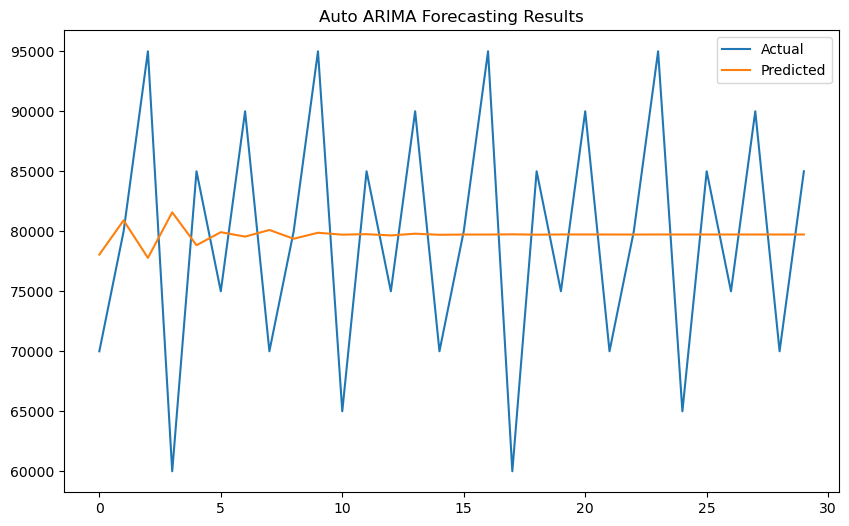

In [296]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error

# Assume df_luar_train and df_luar_test are DataFrames with a 'y' column
# If the column name is different, adjust the code below

# Prepare the data
train_data = df_luar_train['y'].values
test_data = df_luar_test['y'].values

# Fit auto ARIMA model
model = auto_arima(train_data, 
                   start_p=0, start_q=0, 
                   max_p=3, max_q=3, 
                   m=1,  # Seasonality (for non-seasonal data, set m=1)
                   start_P=0, seasonal=False,  # Set seasonal=False for non-seasonal data
                   d=None,  # Let auto_arima determine the order of differencing
                   trace=True,  # Print model summary
                   error_action='ignore',  
                   suppress_warnings=True,  
                   stepwise=True)  # Stepwise search to reduce computation

# Summarize the model
print(model.summary())

# Make predictions
predictions2 = model.predict(n_periods=len(test_data))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_data, predictions2))
print(f'Test RMSE: {rmse:.3f}')

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(test_data, label='Actual')
plt.plot(predictions2, label='Predicted')
plt.legend()
plt.title('Auto ARIMA Forecasting Results')
plt.show()

In [297]:
saldo_awal = 8730000
saldo_akhir_test = 10155000

temp1 = np.array(predictions1)
temp2 = np.array(predictions2)

print(f"Saldo Awal anda adalah {saldo_awal}, dengan saldo akhir (true) adalah {saldo_akhir_test}")
for i in range(len(temp1)):
    saldo_awal = saldo_awal + temp1[i] - temp2[i]

print(f"saldo akhir prediksi anda adalah {saldo_awal}, dengan error sebesar {abs(saldo_akhir_test - saldo_awal)}")

Saldo Awal anda adalah 8730000, dengan saldo akhir (true) adalah 10155000
saldo akhir prediksi anda adalah 10155132.262127787, dengan error sebesar 132.26212778687477


In [298]:
nama_metode.append("Auto Arima")
saldo_akhir.append(round(saldo_awal))
error.append(round(abs(saldo_akhir_test - saldo_awal)))

## ETS

### Pemasukan

ETS(add,add,7) RMSE=20650.393
ETS(add,add,12) RMSE=16412.963
ETS(add,mul,7) RMSE=20574.190
ETS(add,mul,12) RMSE=16472.987
ETS(add,None,None) RMSE=14931.142
ETS(add,None,7) RMSE=14931.142
ETS(add,None,12) RMSE=14931.142
ETS(mul,add,7) RMSE=21144.298
ETS(mul,add,12) RMSE=16416.321
ETS(mul,mul,7) RMSE=21042.109
ETS(mul,mul,12) RMSE=16477.311
ETS(mul,None,None) RMSE=14937.009
ETS(mul,None,7) RMSE=14937.009
ETS(mul,None,12) RMSE=14937.009
ETS(None,add,7) RMSE=20571.568
ETS(None,add,12) RMSE=16228.283
ETS(None,mul,7) RMSE=20571.159
ETS(None,mul,12) RMSE=16225.062
ETS(None,None,None) RMSE=14929.581
ETS(None,None,7) RMSE=14929.581
ETS(None,None,12) RMSE=14929.581
Best ETS(None, None, None) RMSE=14929.581
Test RMSE: 14929.581


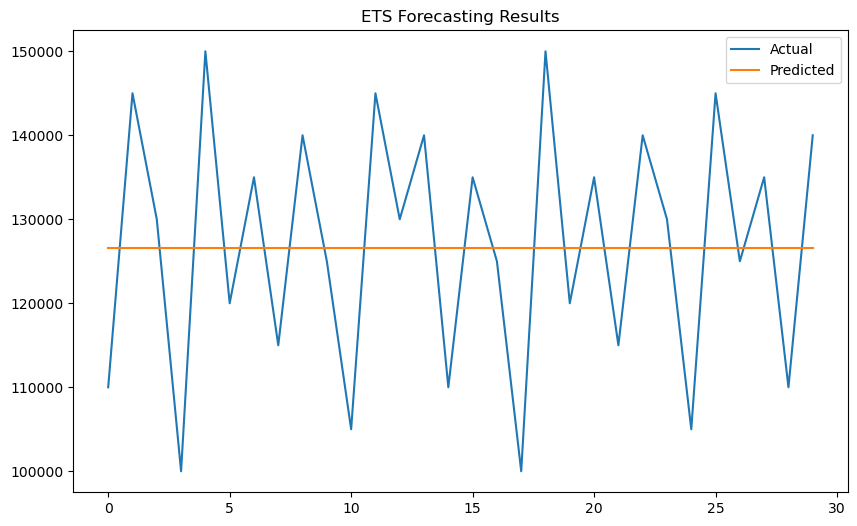

Future predictions: [126524.91200404 126524.91200404 126524.91200404 126524.91200404
 126524.91200404 126524.91200404 126524.91200404 126524.91200404
 126524.91200404 126524.91200404 126524.91200404 126524.91200404
 126524.91200404 126524.91200404 126524.91200404 126524.91200404
 126524.91200404 126524.91200404 126524.91200404 126524.91200404
 126524.91200404 126524.91200404 126524.91200404 126524.91200404
 126524.91200404 126524.91200404 126524.91200404 126524.91200404
 126524.91200404 126524.91200404]


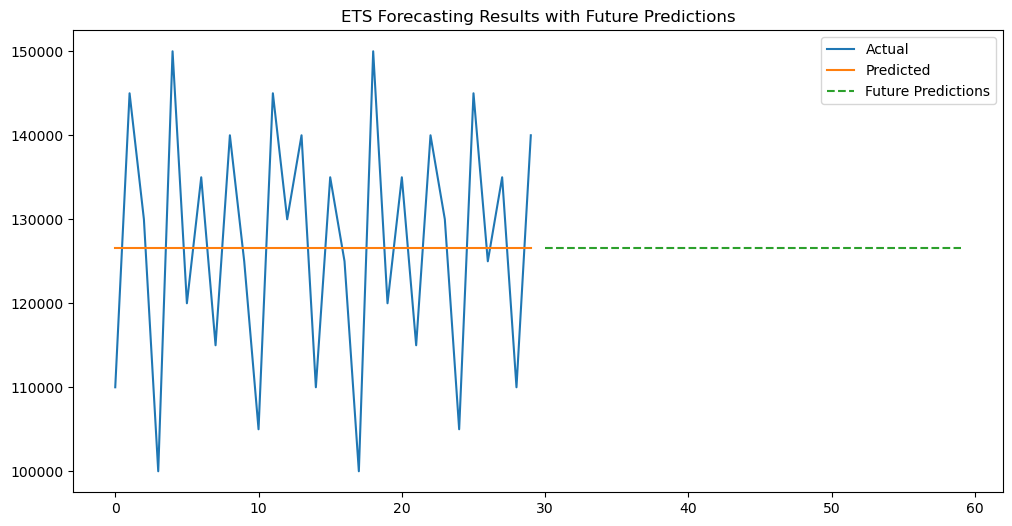

In [301]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from itertools import product

# Function to evaluate ETS model
def evaluate_ets_model(train, test, trend, seasonal, seasonal_periods):
    # Fit model
    model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods)
    model_fit = model.fit()
    
    # Make predictions
    predictions = model_fit.forecast(len(test))
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test, predictions))
    return rmse, model_fit

# Function to perform grid search for ETS parameters
def grid_search_ets(train, test, trends, seasonals, seasonal_periods):
    best_score, best_cfg, best_model = float("inf"), None, None
    for t, s, sp in product(trends, seasonals, seasonal_periods):
        try:
            rmse, model = evaluate_ets_model(train, test, trend=t, seasonal=s, seasonal_periods=sp)
            if rmse < best_score:
                best_score, best_cfg, best_model = rmse, (t, s, sp), model
            print(f'ETS({t},{s},{sp}) RMSE={rmse:.3f}')
        except:
            continue
    print(f'Best ETS{best_cfg} RMSE={best_score:.3f}')
    return best_cfg, best_model

# Prepare the data
train_data = df_masuk_train['y'].values
test_data = df_masuk_test['y'].values

# Define the parameter grid
trends = ['add', 'mul', None]
seasonals = ['add', 'mul', None]
seasonal_periods = [None, 7, 12]  # Adjust based on your data frequency

# Perform grid search
best_params, best_model = grid_search_ets(train_data, test_data, trends, seasonals, seasonal_periods)

# Make predictions using the best model
predictions = best_model.forecast(len(test_data))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_data, predictions))
print(f'Test RMSE: {rmse:.3f}')

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(test_data, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.title('ETS Forecasting Results')
plt.show()

# If you want to make future predictions
future_periods = 30  # Adjust as needed
future_predictions = best_model.forecast(future_periods)
print("Future predictions:", future_predictions)

# Plot including future predictions
plt.figure(figsize=(12, 6))
plt.plot(range(len(test_data)), test_data, label='Actual')
plt.plot(range(len(test_data)), predictions, label='Predicted')
plt.plot(range(len(test_data), len(test_data) + future_periods), future_predictions, label='Future Predictions', linestyle='--')
plt.legend()
plt.title('ETS Forecasting Results with Future Predictions')
plt.show()

### Pengeluaran

ETS(add,add,7) RMSE=14434.130
ETS(add,add,12) RMSE=11423.542
ETS(add,mul,7) RMSE=14560.779
ETS(add,mul,12) RMSE=11423.140
ETS(add,None,None) RMSE=10450.253
ETS(add,None,7) RMSE=10450.253
ETS(add,None,12) RMSE=10450.253
ETS(mul,add,7) RMSE=14489.475
ETS(mul,add,12) RMSE=11423.473
ETS(mul,mul,7) RMSE=14627.444
ETS(mul,mul,12) RMSE=11423.105
ETS(mul,None,None) RMSE=10449.379
ETS(mul,None,7) RMSE=10449.379
ETS(mul,None,12) RMSE=10449.379
ETS(None,add,7) RMSE=14317.159
ETS(None,add,12) RMSE=11282.493
ETS(None,mul,7) RMSE=14321.936
ETS(None,mul,12) RMSE=11283.014
ETS(None,None,None) RMSE=10436.409
ETS(None,None,7) RMSE=10436.409
ETS(None,None,12) RMSE=10436.409
Best ETS(None, None, None) RMSE=10436.409
Test RMSE: 10436.409


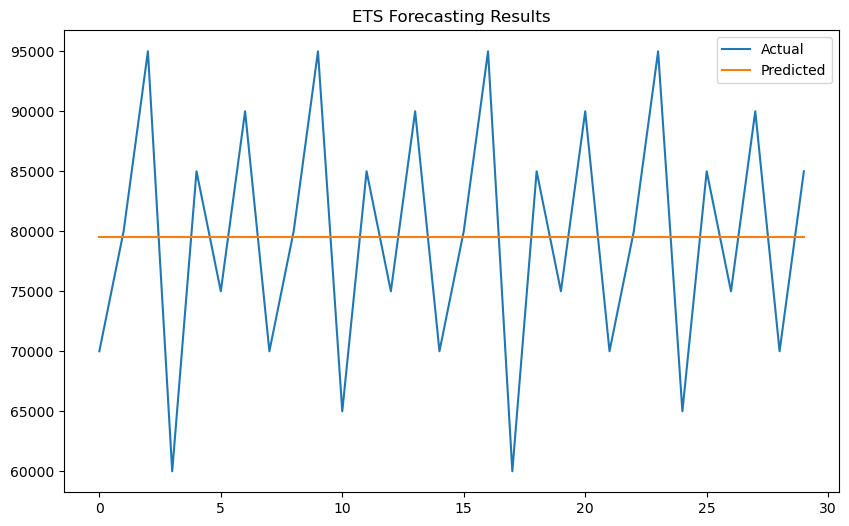

Future predictions: [79544.40156623 79544.40156623 79544.40156623 79544.40156623
 79544.40156623 79544.40156623 79544.40156623 79544.40156623
 79544.40156623 79544.40156623 79544.40156623 79544.40156623
 79544.40156623 79544.40156623 79544.40156623 79544.40156623
 79544.40156623 79544.40156623 79544.40156623 79544.40156623
 79544.40156623 79544.40156623 79544.40156623 79544.40156623
 79544.40156623 79544.40156623 79544.40156623 79544.40156623
 79544.40156623 79544.40156623]


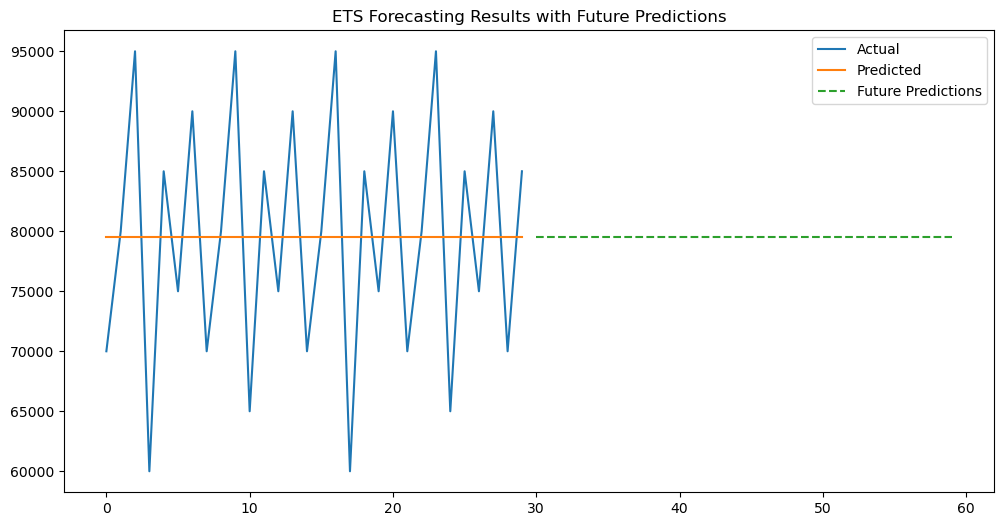

In [303]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from itertools import product

# Assume df_luar_train and df_luar_test are DataFrames with a 'y' column
# If the column name is different, adjust the code below

def evaluate_ets_model(train, test, trend, seasonal, seasonal_periods):
    # Fit model
    model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods)
    model_fit = model.fit()
    
    # Make predictions
    predictions = model_fit.forecast(len(test))
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test, predictions))
    return rmse, model_fit

def grid_search_ets(train, test, trends, seasonals, seasonal_periods):
    best_score, best_cfg, best_model = float("inf"), None, None
    for t, s, sp in product(trends, seasonals, seasonal_periods):
        try:
            rmse, model = evaluate_ets_model(train, test, trend=t, seasonal=s, seasonal_periods=sp)
            if rmse < best_score:
                best_score, best_cfg, best_model = rmse, (t, s, sp), model
            print(f'ETS({t},{s},{sp}) RMSE={rmse:.3f}')
        except:
            continue
    print(f'Best ETS{best_cfg} RMSE={best_score:.3f}')
    return best_cfg, best_model

# Prepare the data
train_data = df_luar_train['y'].values
test_data = df_luar_test['y'].values

# Define the parameter grid
trends = ['add', 'mul', None]
seasonals = ['add', 'mul', None]
seasonal_periods = [None, 7, 12]  # Adjust based on your data frequency

# Perform grid search
best_params, best_model = grid_search_ets(train_data, test_data, trends, seasonals, seasonal_periods)

# Make predictions using the best model
predictions = best_model.forecast(len(test_data))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_data, predictions))
print(f'Test RMSE: {rmse:.3f}')

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(test_data, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.title('ETS Forecasting Results')
plt.show()

# If you want to make future predictions
future_periods = 30  # Adjust as needed
future_predictions = best_model.forecast(future_periods)
print("Future predictions:", future_predictions)

# Plot including future predictions
plt.figure(figsize=(12, 6))
plt.plot(range(len(test_data)), test_data, label='Actual')
plt.plot(range(len(test_data)), predictions, label='Predicted')
plt.plot(range(len(test_data), len(test_data) + future_periods), future_predictions, label='Future Predictions', linestyle='--')
plt.legend()
plt.title('ETS Forecasting Results with Future Predictions')
plt.show()

# Keputusan pemakaian model

In [305]:
df_sum = pd.DataFrame({
    'Nama Metode' : nama_metode,
    'Saldo Akhir' : saldo_akhir,
    'Error' : error
})

df_sum

,Nama Metode,Saldo Akhir,Error
0,prophet,10081129,73871
1,LSTM,10055481,99519
2,Random Forest,10139975,15025
3,SVR,10141640,13360
4,MLP Sklearn,10150683,4317
5,MLP Keras,10162554,7554
6,XGBoost,10156753,1753
7,Arima,10155687,687
8,Auto Arima,10155132,132
